In [1]:
from scipy.sparse import csr_matrix
import implicit
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from metrics import mean_average_presision_k, hitrate_k

In [3]:
# from sacred.observers import 

In [4]:
# Load data

In [5]:
path = '/data/pet_ML/groupLe_recsys/gl/'
df_prefix = '30k/'

test_df = pd.read_csv(path + df_prefix + 'test/views.csv')

train_df = pd.read_csv(path + df_prefix + 'train/views.csv')
train_df.head(2)

,user_id,item_id,rate
0,24,4474214,0
1,24,4479846,0


<AxesSubplot:>

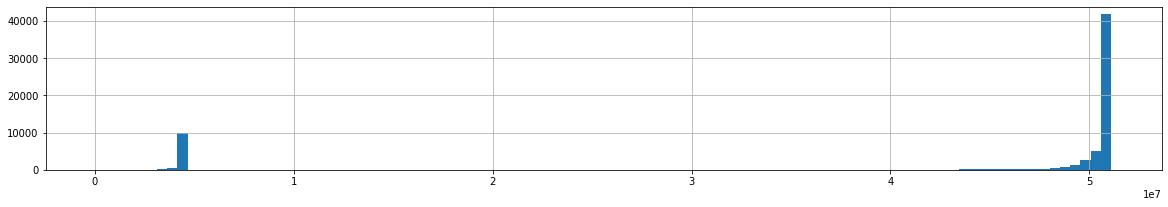

In [9]:
train_df.item_id.drop_duplicates().hist(bins=100, figsize=(20, 3))

<AxesSubplot:>

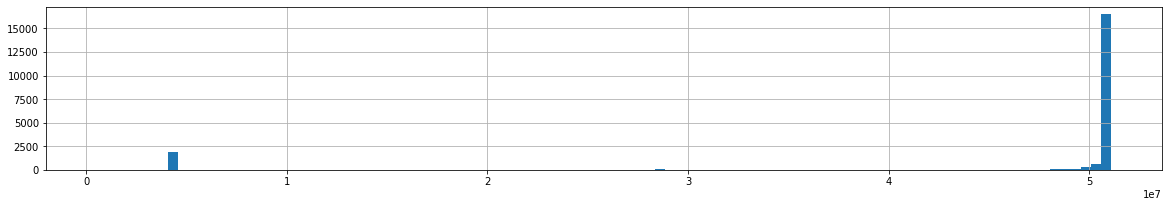

In [10]:
test_df.item_id.drop_duplicates().hist(bins=100, figsize=(20, 3))

In [4]:
# delete negative samples
train_df.shape

(1397434, 3)

In [5]:
d = train_df.groupby('user_id').sum()['rate']
dislikers = d[d <= 0].index.to_list()

In [6]:
test_items = test_df.item_id.drop_duplicates()

train_df = train_df[train_df.item_id.isin(test_items) & (~train_df.user_id.isin(dislikers))]
test_df = test_df[(test_df.user_id.isin(train_df.user_id.drop_duplicates()))]
train_df.shape

(954462, 3)

In [7]:
calc_preference = lambda v: 1 if v>0 else -10
train_df['metric']= train_df.rate.apply(calc_preference)

alpha = 10
train_df.metric = train_df.metric * alpha * train_df.rate

train_df.rate = train_df.metric
train_df = train_df.drop('metric', axis=1)

In [8]:
df_users = pd.read_csv(path + df_prefix + 'users.csv')
df_users.head(2)

,id,user_id,username
0,647898,706795,Niwin
1,211054,402165,Sertenopolis


In [9]:
df_manga = pd.read_csv(path+ df_prefix + 'manga.csv')
df_manga.head(2)

,id,title,link
0,51018545,Полицейский и старшеклассница,https://doramatv.live/p_and_jk
1,50934076,Моральная принцесса,/internal/red/234793


# Filter data

<AxesSubplot:>

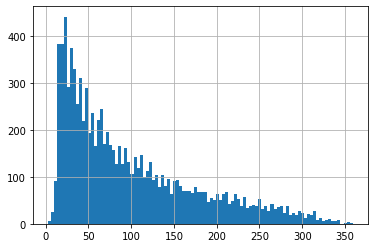

In [10]:
train_df.groupby('user_id').count()['rate'].hist(bins=100)

# indexing data sequentially

In [11]:
users = sorted(train_df.user_id.drop_duplicates().to_list())
items = sorted(train_df.item_id.drop_duplicates().to_list())
print(len(users), len(items))

9644 18885


In [12]:
users_pivot = pd.DataFrame.from_records([(uid, i) for i, uid in enumerate(users)], columns='user_id user_index'.split())
items_pivot = pd.DataFrame.from_records([(iid, i) for i, iid in enumerate(items)], columns='item_id item_index'.split())
users_pivot.head()

,user_id,user_index
0,24,0
1,85,1
2,97,2
3,186,3
4,192,4


In [13]:
train_df = pd.merge(train_df, users_pivot, on='user_id')
train_df = pd.merge(train_df, items_pivot, on='item_id') 
train_df.head()

,user_id,item_id,rate,user_index,item_index
0,24,4474214,0,0,751
1,10602,4474214,0,110,751
2,12330,4474214,0,130,751
3,12531,4474214,0,134,751
4,19042,4474214,0,190,751


In [14]:
indexed_df = train_df.drop('user_id item_id'.split(), axis=1)
indexed_df.head()

,rate,user_index,item_index
0,0,0,751
1,0,110,751
2,0,130,751
3,0,134,751
4,0,190,751


In [15]:
users = indexed_df.user_index.to_list()
items = indexed_df.item_index.to_list()
rate  = indexed_df.rate.to_list()

shape = (len(set(users)), len(set(items)))
ui_mat = csr_matrix((rate, (users, items)), shape=shape)

In [16]:
ui_mat.shape

(9644, 18885)

In [32]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True, iterations=20)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(ui_mat)

KeyboardInterrupt: 

# Calc metrics

In [25]:
ui_mat.shape

(9644, 18885)

In [26]:
recs = []

k = 100
for uid, uix in tqdm(list(users_pivot.to_records(index=False))):
    recs.append(model.recommend(uix, ui_mat, N=k, filter_already_liked_items=False))

In [28]:
gt = test_df.groupby('user_id')['item_id'].apply(list).tolist()

items_pivot_dict = {rec_id : item_id for item_id, rec_id in list(items_pivot.to_records(index=False))}
# select only items ids and map it to real ids. Without mapping cant calculating metrics with gt dataframe 
rec_items = list(map(lambda rec_list: [items_pivot_dict[x[0]] for x in rec_list], recs))

In [29]:
mean_average_presision_k(rec_items, gt, k=k)

0.003069265864786389

In [30]:
hitrate_k(rec_items, gt, k=k)

0.014724180837826627